# GIS GZ – Übung 9: Thematische Karten

### Grobziele
* Sie können eine thematische Karte nach wissenschaftlichen Kriterien und kartografischen Prinzipien erstellen. 

### Feinziele
* Sie können die unterschiedlichen Join-Methoden beschreiben und erklären. 
* Sie können die Funktionsweise von drei unterschiedlichen Klassifizierungsmethoden beschreiben. 
* Sie erkennen auf einer Karte, mit welcher Methode der Datensatz klassifiziert wurde. 
* Sie können erklären, weshalb Choroplethenkarten nach bestimmten Regeln gestaltet werden sollten.
* Sie können tabellarische Daten an Geodaten joinen. 
* Sie können Daten normalisieren. 
* Sie können Datensätze nach unterschiedlichen Methoden klassifizieren und darstellen.


### Projekt
* Sie arbeiten an der Lösung Ihrer Fragestellung und wenden die erlernten Techniken aktiv an. 

## Einleitung
In der heutigen Übung betrachten wir die Bevölkerungsentwicklung (Männer + Frauen || Schweizer + Ausländer) in den Gemeinden des Kantons Zürich. Dazu haben wir einen Datensatz, der die totalen Bevölkerungszahlen von 1981 bis und mit 2018 angibt. Angenommen, dass wir von den heutigen Gemeinden ausgehen (also nach allen Gemeindefusionen), berechnet sich die Bevölkerungsdichte dadurch, dass die Azahl an Einwohnern durch die Gemeindefläche geteilt wird. Menschen können aber auf einen Blick nur rund 10 Farben wahrnehmen, sodass eine kontinuierliche Farbskala für alle Gemeinden schwer zu interpretieren wäre. Aus diesem Grund wenden wir Klassifizierungen an, die uns die Bevölkerungsdichte in einer Kategorie zurückgibt. Interessant wird es dann, wenn Sie eine Analyse über die Zeit machen, also unterschiedliche Zeitstände miteinander vergleichen. Dazu eignen sich die Methoden der Geoinformatik besonders. 

## Grundregeln
Es sind nicht viele, aber dafür sind sie umso wichtiger:
1) Choroplethenkarten müssen immer mit relativen Werten dargestellt werden! Andersum: In die Flächen kommen immer relative Werte - nie absolute Werte!
2) Faustregel: Wählen Sie 5-8 Kategorien.
3) Vermeiden Sie rot-grüne Farbschemen, da 11% der Männer eine Rot-Grün-Sehschwäche haben. 

## Vorgehen
* Laden Sie mit GeoPandas einen Geodatensatz
* Laden Sie mit Pandas einen Tabellendatensatz und joinen Sie diesen an den Geodatensatz
* Berechnen Sie daraus die Bevölkerungsdichte pro Jahr und speichern Sie diese Information in separaten Spalten
* Klassifizieren Sie mit PySAL und ziehen Sie daraus wichtige Statistiken (z.B. über die Bingrösse)
* Plotten Sie einen Zeitstand und eine Klassifizierungsmethode mit GeoPandas
* Passen Sie den Code so an, dass Sie sich für drei Zeitstände nachfolgend Karten ausgeben lassen und die dann analysieren.
* Erörtern Sie, wie sich die Verteilungen ändern, wenn Sie die Klassifizierungsmethode ändern. 

## Dateien
In dieser Aufgabe erhalten Sie drei Dateien:
* `kanton_zuerich_gemeindegebiet.json` die Geodaten mit den Gemeinden des Kantons Zürich (Achtung: es gibt ein paar Fehler bzw. Inkonsistenzen!)
* `bfs_totale_bevoelkerung_kanton_zuerich_1981_2018.csv` die totale Bevölkerungsanzahl pro Gemeinde anhand der BFS-Nummer des Jahrs 2018 (ohne Unterscheidung zwischen Männern und Frauen bzw. Schweizern und Ausländern)
* `requirements.py` ein Zusatzmodul mit der Plot-Funktion

## Besonderes
* Achtung mit den Encodings beim Importieren von Datensätzen!
* Matplotlib ist eine sehr mächtige Library und kann extrem viel. GeoPandas nutzt Matplotlib, lässt aber nicht in allen Punkten alle Freiheiten zu. Kommen Sie bei Fragen auf die Assistenz zu.

#### Vorbereitungen

In [4]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pprint import pprint
import pysal.viz.mapclassify as mc
from data.requirements import show_results_geopandas


# Define important paths
table = os.path.join('data', 'bfs_totale_bevoelkerung_kanton_zuerich_1981_2018.csv')
shapes = os.path.join('data', 'kanton_zuerich_gemeindegebiet.json')

# Read the data into Pandas and GeoPandas
geometries = gpd.read_file(shapes)
table_data = pd.read_table(table, encoding='latin-1', delimiter=';')

# Join the columns of the DataFrame to the GeoDataFrame and extract the area to a new column
df = geometries.merge(table_data, on='BFS_NUMMER')
df['area'] = df.geometry.area

# As duplicate entries for one BFS_NUMMER might exist (due to exclaves), sum up the areas
# for all rows that correspond to the same BFS_NUMMER
all_unique_bfs_nr = list(dict.fromkeys(df.BFS_NUMMER))
for bfs_nr in all_unique_bfs_nr:
    rows = df.loc[df.BFS_NUMMER == bfs_nr]
    number_of_rows = len(rows)
    if number_of_rows > 1:
        total_area = rows.area.sum()
        df.loc[df.BFS_NUMMER == bfs_nr, 'area'] = total_area

# Normalize the entries and store the normalized values to new columns named "normalized_{YEAR}"
year_columns = list(table_data.columns[2:])
for entry in year_columns:
    new_label = 'normalized_{}'.format(entry.rsplit('_')[-1])
    df[new_label] = df[entry] / df['area'] * 1000000


#### Paramter für die Analyse bzw. für den Output festlegen

In [5]:
# These are the classification methods you can choose from
classification_methods = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']

# Set the initial values for your analysis and determine the category bins
title = 'Bevölkerungsdichte der Gemeinden des Kantons Zürich'
subtitle = 'Quantiles'
legend_title = 'Anzahl Einwohner pro km²'
number_of_categories = 6
selected_column_name = 'normalized_2016'
selected_classification = 'quantiles'
data_categories = mc.Quantiles(df[selected_column_name], k=number_of_categories)
print(data_categories.bins)
print(data_categories)

[ 154.51254812  324.70685329  527.81852817  753.40118624 1309.68854455
 4320.30911416]
                 Quantiles                  
 
 Lower              Upper              Count
           x[i] <=  154.513               28
 154.513 < x[i] <=  324.707               27
 324.707 < x[i] <=  527.819               27
 527.819 < x[i] <=  753.401               27
 753.401 < x[i] <= 1309.689               27
1309.689 < x[i] <= 4320.309               27


#### Plotfunktion ausführen

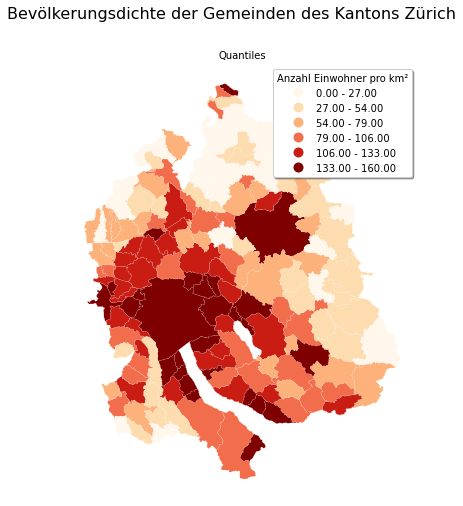

In [3]:
# Apply the plotting function for showing the results. METHOD 2
show_results_geopandas(df, number_of_categories, title, subtitle, legend_title, selected_column_name, selected_classification)

## Aufgaben
1) Passen Sie die Funktion oben so an, dass Sie sich drei Zeitstände ausgeben können. Wählen Sie dabei den Zeitstand selbstständig aus. Welche Gebiete haben sich verändert? Worin können mögliche Gründe dafür liegen?

2) Variieren Sie die Klassifizierungsmethoden und notieren Sie sich, was Ihnen auffällt. Welche Methode(n) würden Sie bevorzugen? Warum?


## Weiterführende Aufgaben (freiwillig, ohne Musterlösung)
* Passen Sie die Funktion `show_results_geopandas` nach Ihren Wünschen an und ändern Sie z.B. das Farbschema oder die Lage der Legende oder die Schattierung. 
* Erstellen Sie einen Algorithmus, der für eine bestimmte Gemeinde über den zeitlichen Verlauf ein Säulendiagramm erstellt, wie sich die Kategoriesierung im Laufe der Zeit geändert hat. 
* Plotten Sie diese Säulendiagramme für alle Gemeinden und verorten Sie sie in die jeweiligen Zellzentroide. Wie gehen Sie mit den beiden Gemeinden um, die eine Exklave haben?


# Projekt
Arbeiten Sie am Projekt weiter und wenden Sie das, was Sie heute gelernt haben, auf Ihr Projekt an. 